# Decision Tree

Decision Tree Classifiers are suitable for this type of classifications as they automatically solves the colinearity issues presented by the different sensor types. For any given split, sensors of the same type will be used only if the information they provide is greater than that already gained by correlation.

In [1]:
# Import libraries needed
from math import pow
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Data setup

In [2]:
# Read dataset and create training an testing datasets
df = pd.read_csv('../Occupancy_Estimation.csv')
feature_data = df.drop(columns=["Room_Occupancy_Count", "Date", "Time"])
X_train, X_test, Y_train, Y_test = train_test_split(feature_data, df["Room_Occupancy_Count"], test_size=0.2)

## Support functions

The `calculate_precision()` and `calculate_recall()` functions are used to obtain the Decision Tree's score. The `get_tree_description()` function is used to print out the tree's structure.

In [3]:
def calculate_precision(y_true, y_pred):
    '''    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    # If prediction was correct, both values are '1' and result is '1'. Otherwise, result is either '0', or '0.5'.
    true_p = (y_true + y_pred) / 2

    # Sum number of correct predictions
    true_p = true_p[true_p == 1].sum()

    # Sum number of points predicted as true
    pred_p = y_pred[y_pred == 1].sum()
    
    # Return precision
    return true_p / pred_p

def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    Returns recall as a floating point number between 0.0 and 1.0
    '''

    # If prediction was correct, both values are '1' and result is '1'. Otherwise, result is either '0', or '0.5'.
    true_p = (y_true + y_pred) / 2
    
    # Sum number of correct predictions
    true_p = true_p[true_p == 1].sum()
    
    # Sum number of points that really are true
    real_p = y_true[y_true == 1].sum()
    
    # Return recall
    return true_p / real_p


In [4]:
def get_tree_description(tree, features):
    '''
    Prints out the structure of a decision tree, identifying node depths and split conditions.
    Original code at https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    '''

    # Store tree attributes
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    
    # Get decision output for tree nodes
    labels = []
    for value in tree.tree_.value:
        labels.append(tree.classes_[np.argmax(value)])

    # Initialize support arrays
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    # start with the root node id (0) and its depth (0)
    stack = [(0, 0)]  

    # While there are still nodes to visit
    while len(stack) > 0:

        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]

        # If a split node, 
        if is_split_node:
            # append left and right children and depth to `stack`
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            # Otherwise, identify as leaf
            is_leaves[node_id] = True

    # Print number of nodes
    print("The binary tree structure has {n} nodes and has the following tree structure:\n".format(n=n_nodes))
    
    # Print tree structure
    # For each node in the tree
    for i in range(n_nodes):

        # If node is a leaf, print its index and output class
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with label={label}.".format(
                    space=node_depth[i] * "\t", node=i, label=labels[i]
                )
            )
        # Otherwise, 
        else:
            # Print node index, left node, right node and split condition
            print(
                "{space}node={node} is a split node: go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=features[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )

    # Get a list of classes as strings
    str_classes = [str(label) for label in tree.classes_]
    
    # Set plot size
    plt.figure(figsize=(pow(2, 6), pow(2, 6)))

    # Plot tree structure
    plot_tree(tree, feature_names=features, class_names=str_classes, filled=True, node_ids=True, rounded=True)
    plt.show()

## Model Creation

In [5]:
# Create a Decision Tree and fit it to training data
dt = DecisionTreeClassifier(ccp_alpha=0.0).fit(X_train, Y_train)

# Get predictions for testing data
predictions = dt.predict(X_test)

# Print Precision, Recall, and tree's depth
print("Precision: " + str(calculate_precision(Y_test, predictions)))
print("Recall: " + str(calculate_recall(Y_test, predictions)))
print("Tree depth: " + str(dt.get_depth()))

Precision: 1.0
Recall: 0.98989898989899
Tree depth: 12


The binary tree structure has 91 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if S1_Light <= 92.0 else to node 22.
	node=1 is a split node: go to node 2 if S5_CO2_Slope <= 0.45576922595500946 else to node 15.
		node=2 is a split node: go to node 3 if S7_PIR <= 0.5 else to node 12.
			node=3 is a split node: go to node 4 if S1_Sound <= 0.16499999910593033 else to node 5.
				node=4 is a leaf node with label=0.
				node=5 is a split node: go to node 6 if S5_CO2_Slope <= 0.09807692840695381 else to node 9.
					node=6 is a split node: go to node 7 if S2_Sound <= 0.7650000303983688 else to node 8.
						node=7 is a leaf node with label=0.
						node=8 is a leaf node with label=3.
					node=9 is a split node: go to node 10 if S1_Light <= 11.5 else to node 11.
						node=10 is a leaf node with label=3.
						node=11 is a leaf node with label=0.
			node=12 is a split node: go to node 13 if S5_CO2 <= 405.0 else to node 14.
				node=13 is a leaf node with la

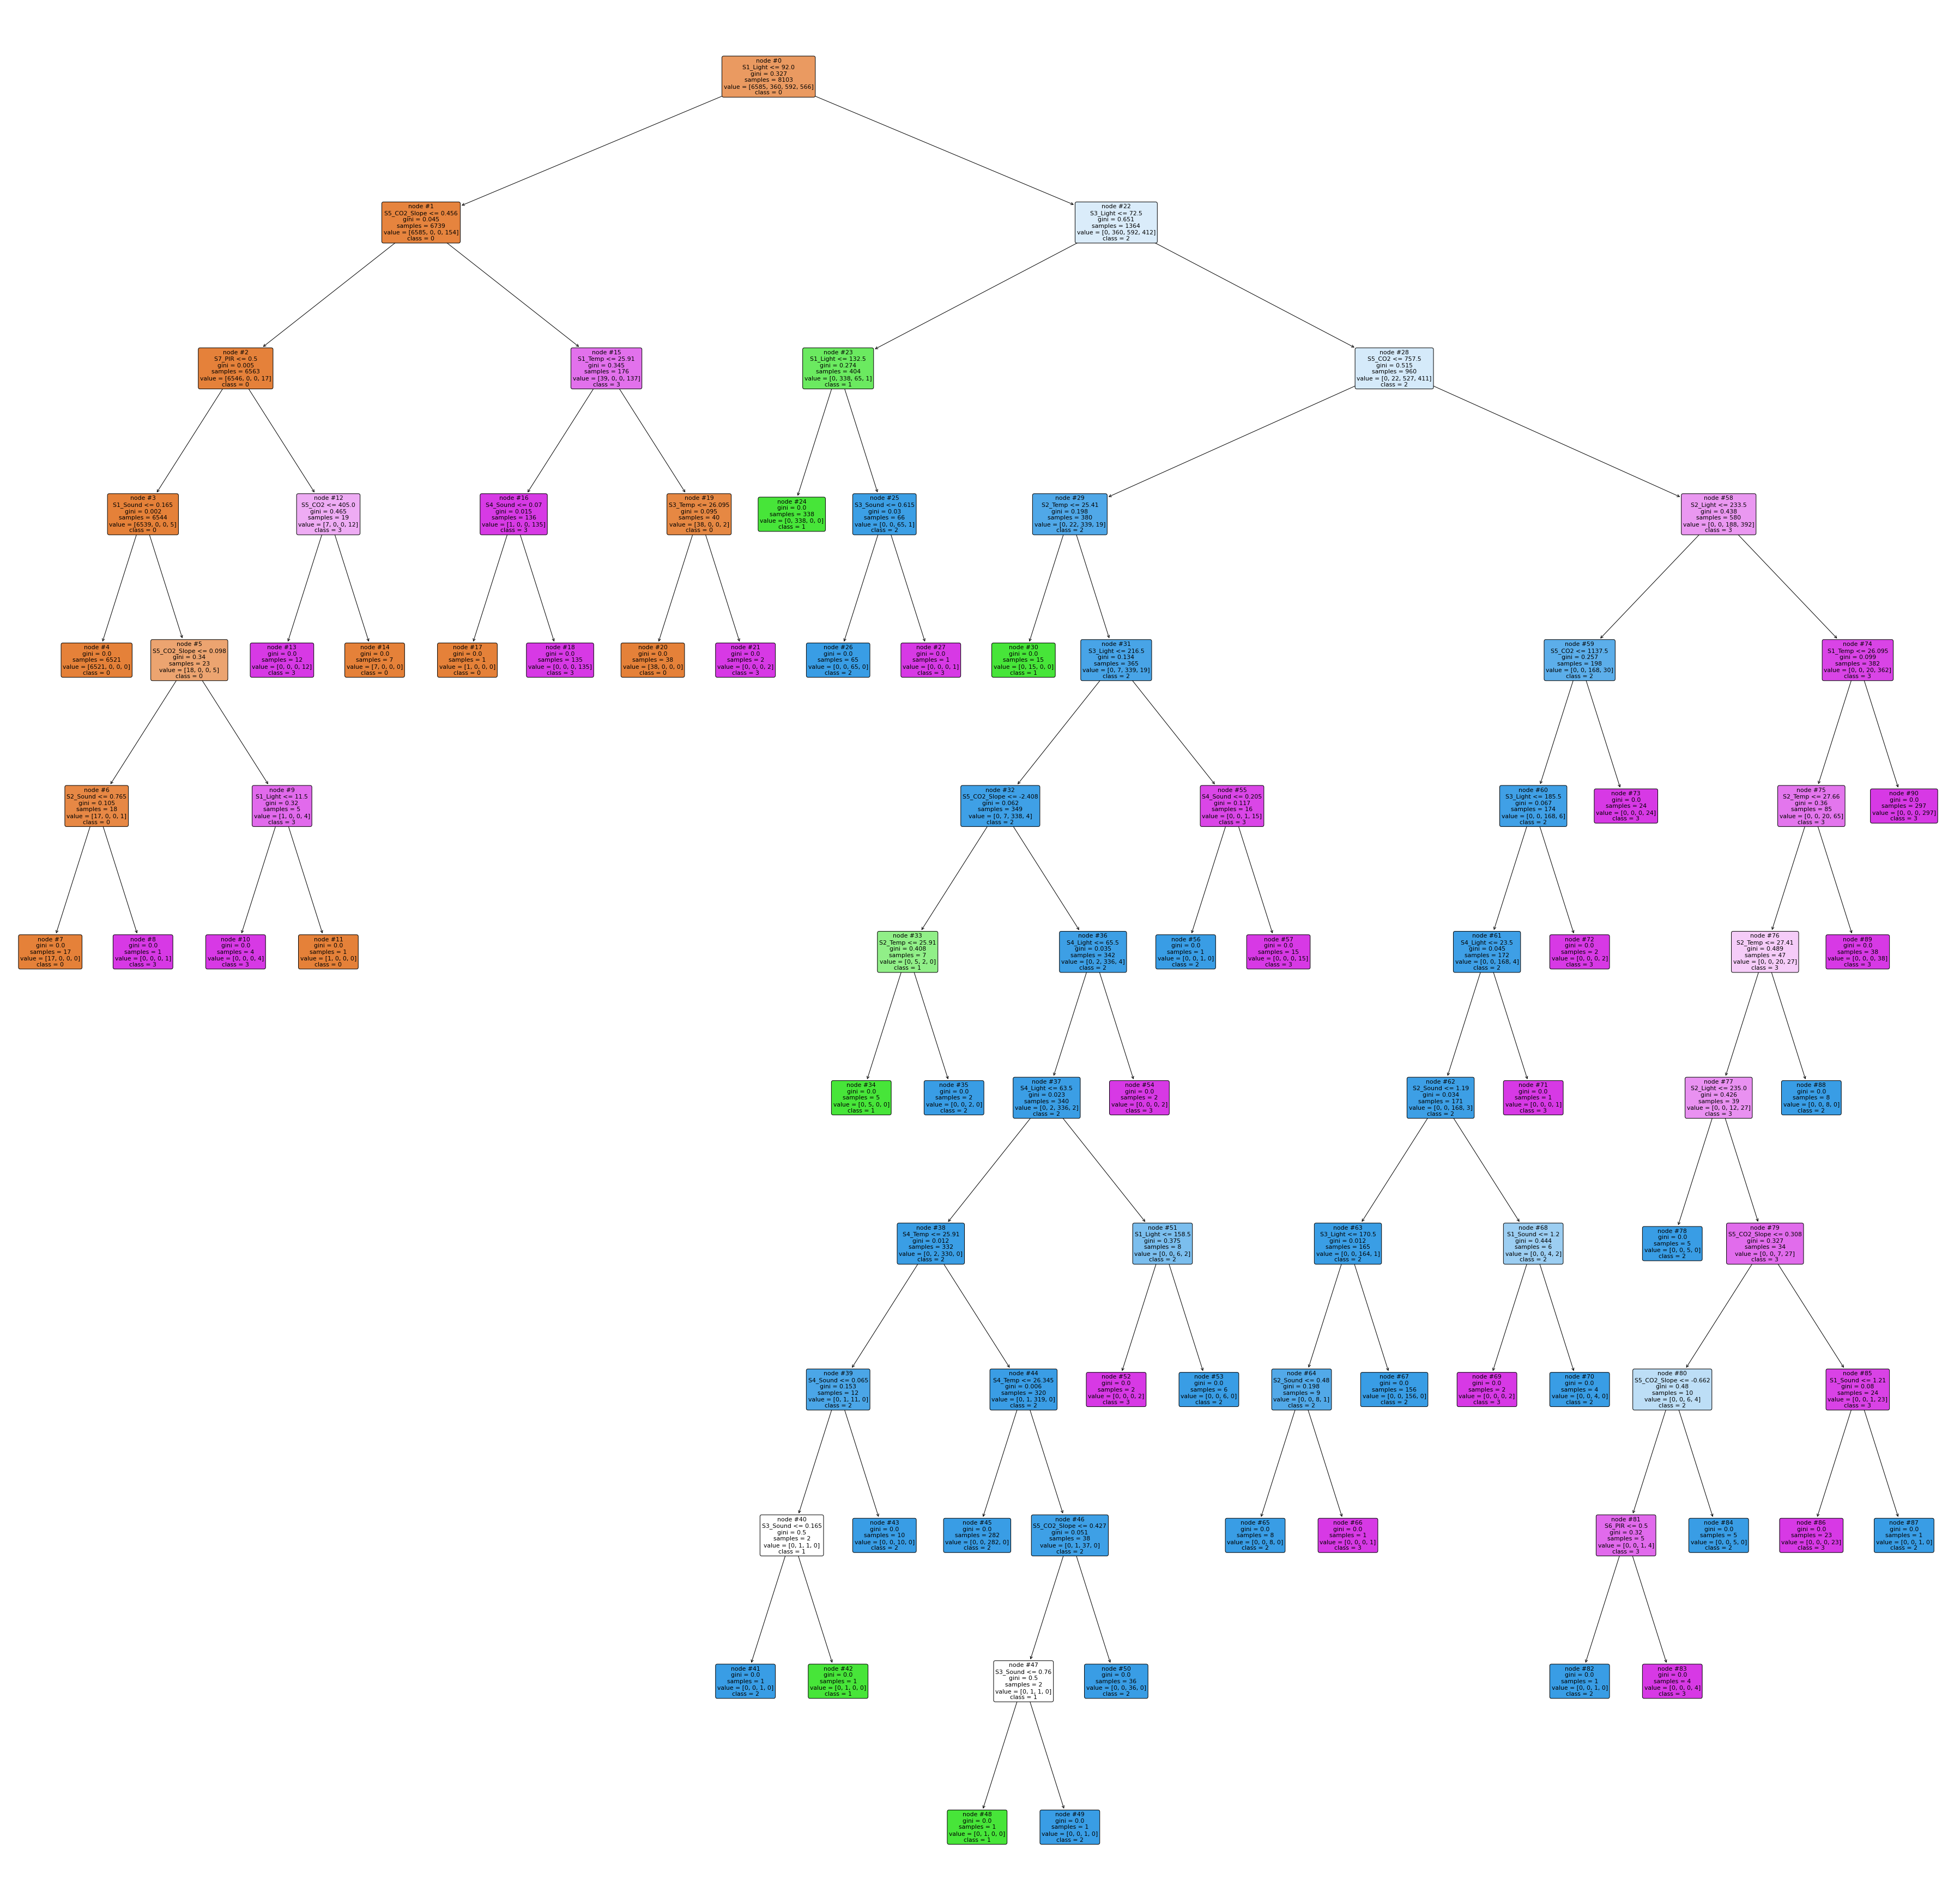

In [6]:
# Print tree's description and plot its graph
get_tree_description(dt, feature_data.columns)

## Model reduction (Cost Complexity Pruning)

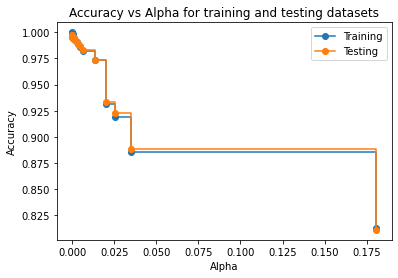

In [7]:
# Apply Cost Complexity Pruning to model
path = dt.cost_complexity_pruning_path(X_train,Y_train)         # Post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities       # Get ccp_alphas and node impurities

# Create a vector with new classifiers for each alpha 
clfs = [DecisionTreeClassifier(ccp_alpha=alpha).fit(X_train, Y_train) for alpha in ccp_alphas]
    
# Create a list of training and testing scores
train_scores = []
test_scores = []

# For each classifier, store training and testing scores
for clf in clfs:
    train_scores.append(clf.score(X_train, Y_train))
    test_scores.append(clf.score(X_test, Y_test))

# Plot Accuracy vs Alpha
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha for training and testing datasets")
ax.plot(ccp_alphas, train_scores, marker='o', label="Training", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="Testing", drawstyle="steps-post")
ax.legend()
plt.show() 



In [8]:
# Print Table header
print("Index", "\t", "Alpha", "\t", "\t", "\t",  "Depth", "\t", "Node Count", "\t", "Training score", "\t", "Testing Score")

# Print the index, alpha, depth, node count and scores for trees of depht 5 or smaller
for i in range(len(ccp_alphas)):
    if(clfs[i].get_depth() <= 5):
        print(i, "\t", f'{ccp_alphas[i]:.19f}', "\t", clfs[i].get_depth(), "\t", clfs[i].tree_.node_count,
              "\t","\t", f'{train_scores[i]:.19f}', "\t", f'{test_scores[i]:.19f}')

Index 	 Alpha 	 	 	 Depth 	 Node Count 	 Training score 	 Testing Score
22 	 0.0009210808193291585 	 5 	 25 	 	 0.9941996791311860093 	 0.9940769990128331957
23 	 0.0010912137804711705 	 5 	 23 	 	 0.9933358015549796916 	 0.9935834155972359527
24 	 0.0018607263782820125 	 5 	 21 	 	 0.9927187461434037186 	 0.9925962487660414668
25 	 0.0031695185516037081 	 5 	 19 	 	 0.9909909909909909720 	 0.9911154985192497380
26 	 0.0032491637720228044 	 5 	 17 	 	 0.9891398247562631640 	 0.9886475814412635232
27 	 0.0048528796757422183 	 4 	 15 	 	 0.9861779587806984715 	 0.9871668311944719054
28 	 0.0067790466460893543 	 4 	 13 	 	 0.9817351598173515992 	 0.9832181638696939618
29 	 0.0134256113504723287 	 4 	 11 	 	 0.9737134394668641724 	 0.9738400789733464569
30 	 0.0203670205489525358 	 2 	 7 	 	 0.9315068493150684414 	 0.9328726554787759584
31 	 0.0254638686150292538 	 2 	 5 	 	 0.9194125632481796595 	 0.9230009871668312105
32 	 0.0348769999520284757 	 1 	 3 	 	 0.8857213377761322670 	 0.88795

As we can see, the 23<sup>rd</sup> tree is the smallest tree that still achieves scores above 0.99. Therefore, it is suitable to utilize this tree for room occupancy estimation while still having a simple decision path for any given input.

The binary tree structure has 23 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if S1_Light <= 92.0 else to node 8.
	node=1 is a split node: go to node 2 if S5_CO2_Slope <= 0.45576922595500946 else to node 5.
		node=2 is a split node: go to node 3 if S7_PIR <= 0.5 else to node 4.
			node=3 is a leaf node with label=0.
			node=4 is a leaf node with label=3.
		node=5 is a split node: go to node 6 if S1_Temp <= 25.90999984741211 else to node 7.
			node=6 is a leaf node with label=3.
			node=7 is a leaf node with label=0.
	node=8 is a split node: go to node 9 if S3_Light <= 72.5 else to node 12.
		node=9 is a split node: go to node 10 if S1_Light <= 132.5 else to node 11.
			node=10 is a leaf node with label=1.
			node=11 is a leaf node with label=2.
		node=12 is a split node: go to node 13 if S5_CO2 <= 757.5 else to node 18.
			node=13 is a split node: go to node 14 if S2_Temp <= 25.40999984741211 else to node 15.
				node=14 is a leaf node with label=1.

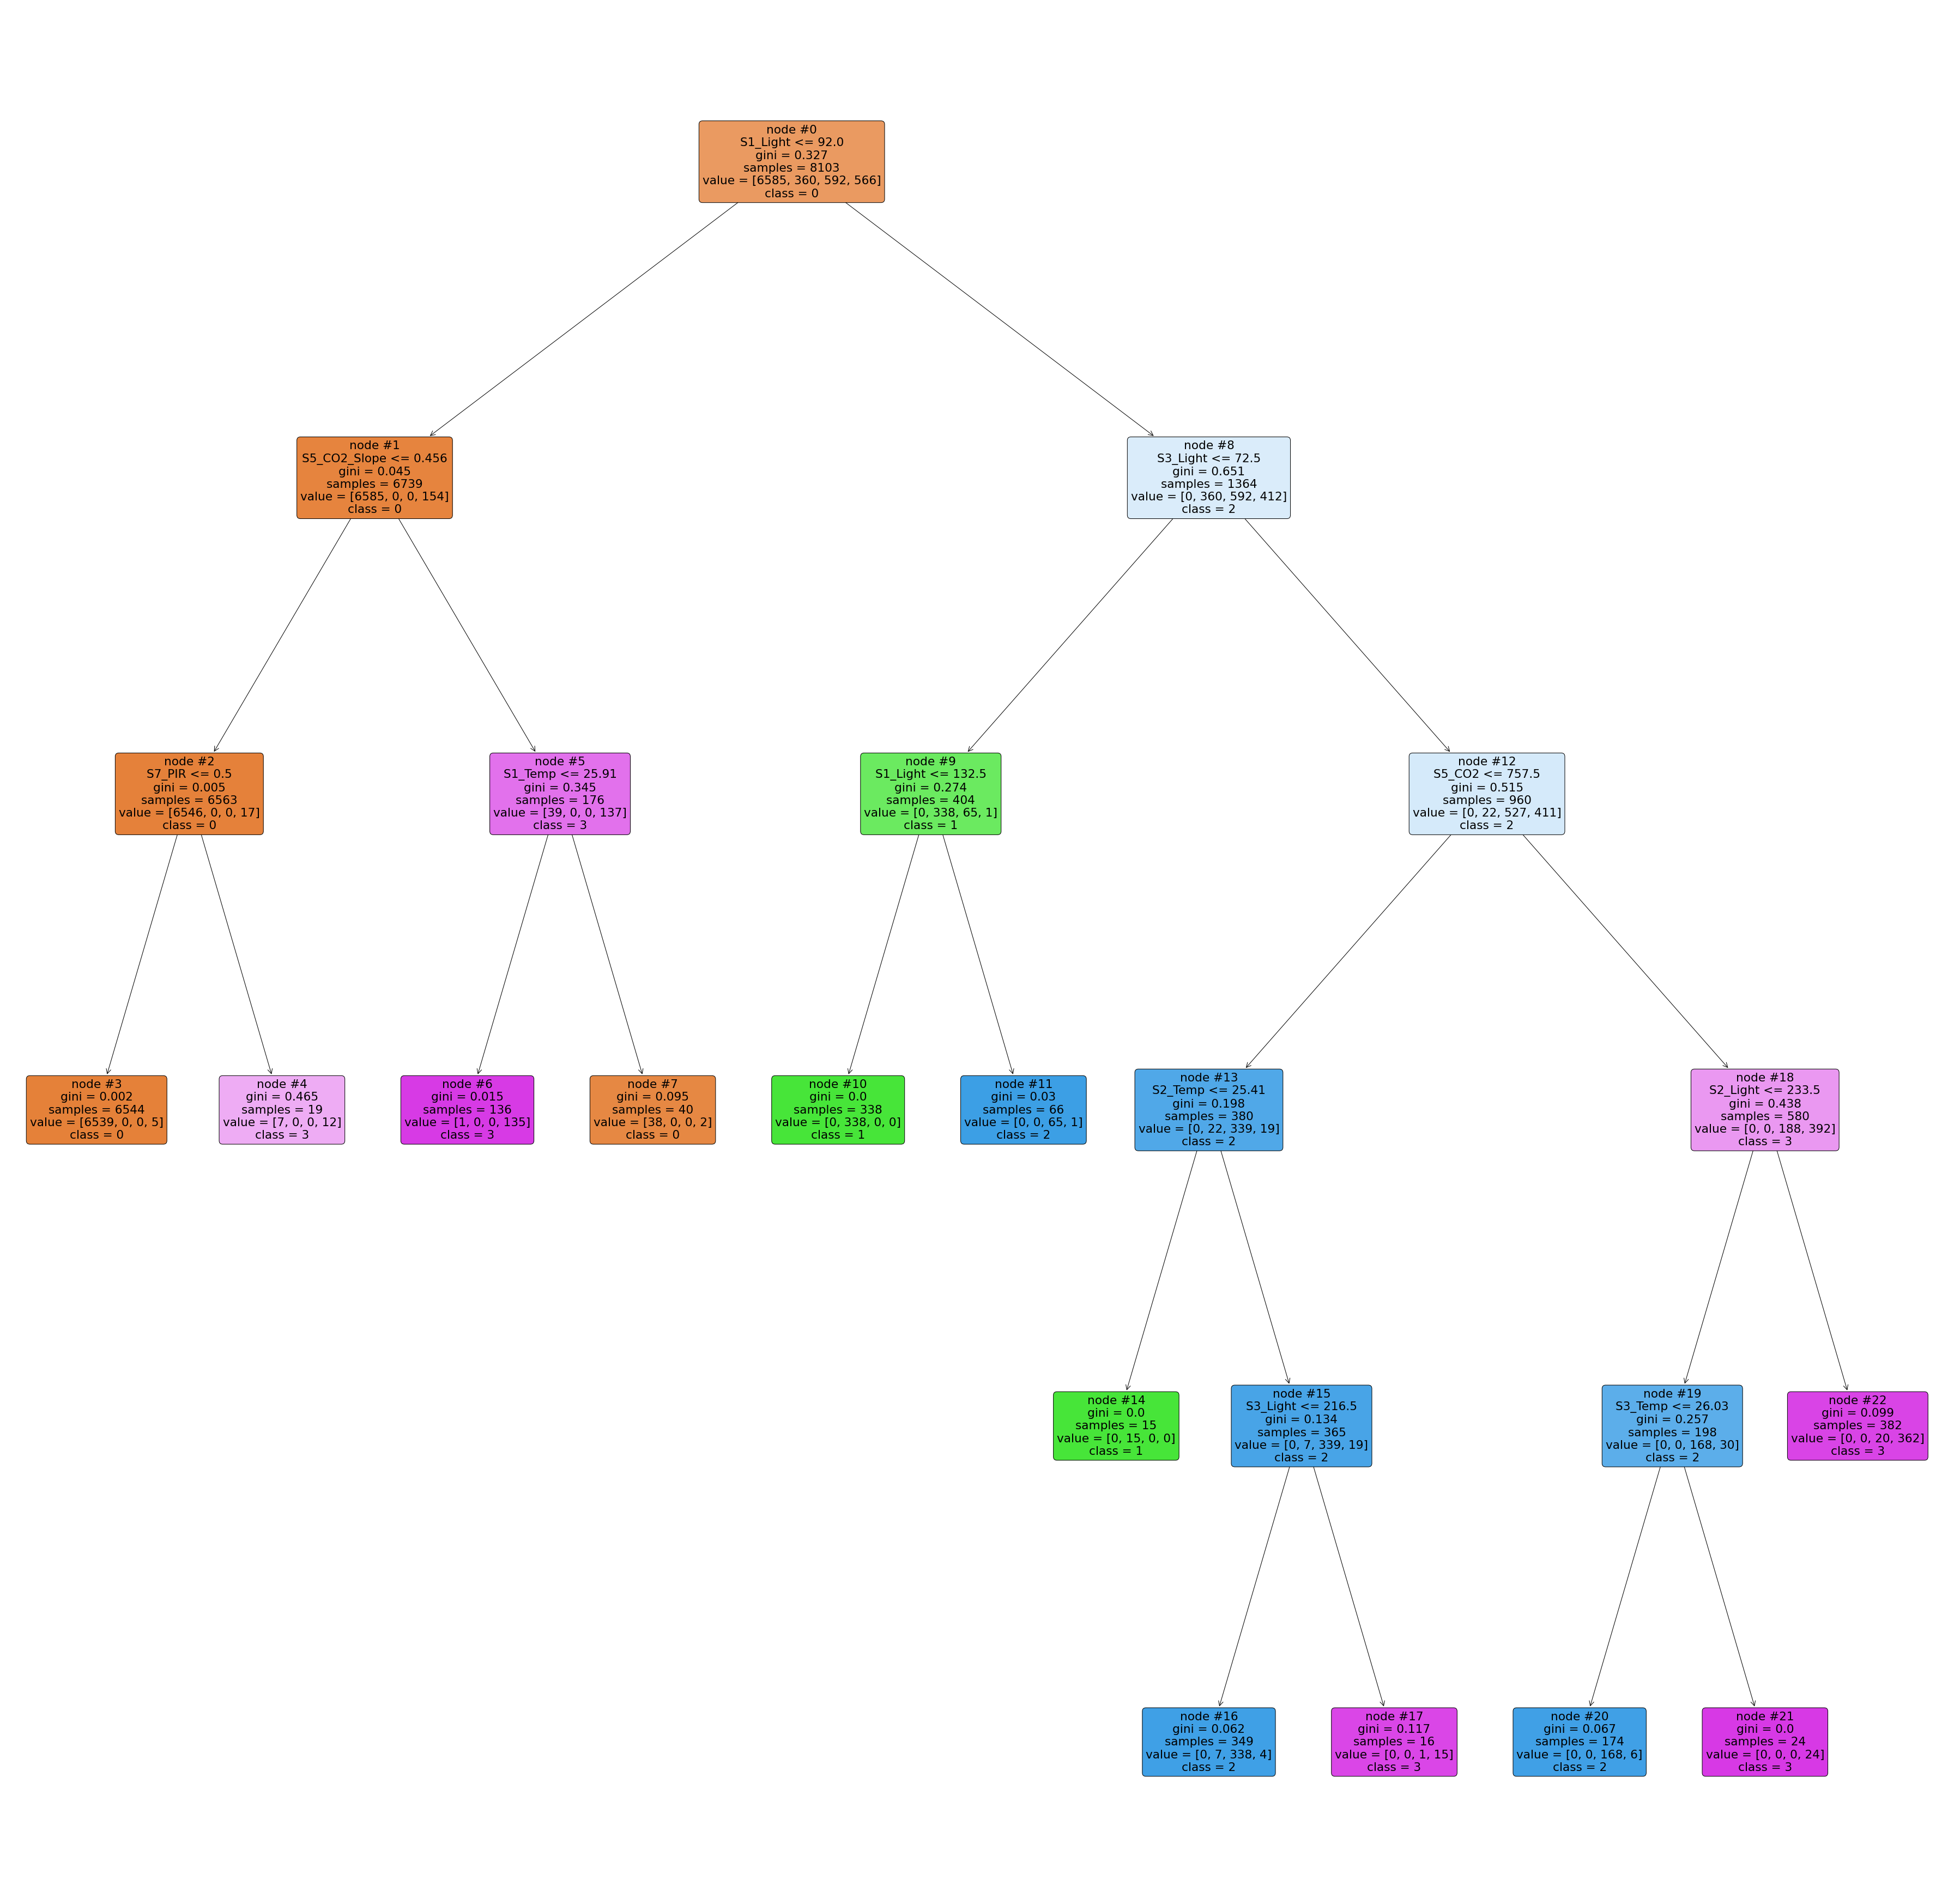

In [9]:
# Get description and plot for 23rd Decision Tree
get_tree_description(clfs[23], feature_data.columns)

## Results

Although a Decision Tree Classifier may achieve a high or even perfect score, its resulting size may make it difficult to understand. As seen above, using Cost Complexity Pruning it is easy to balance the classifier' accuracy with its depth, obtaining trees with similar accuracy but a lower structure complexity.

It will be up to the final user to decide how much precision can be sacrificed to reduce the tree's structure.